In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
# import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9145 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names

In [5]:
class_name = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

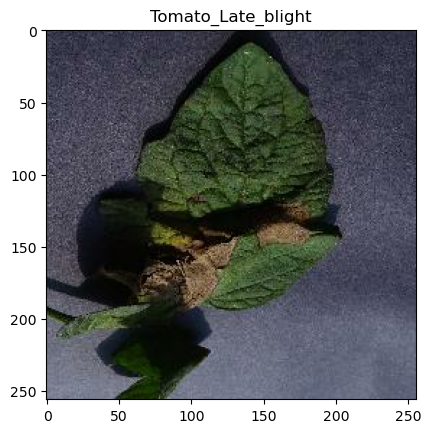

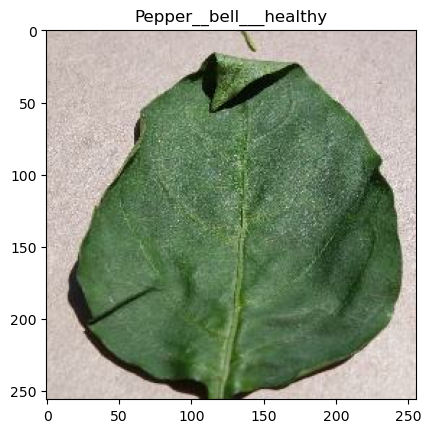

In [7]:
for image_batch, label_batch in dataset.take(2):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.show()

In [6]:
def get_partition(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_partition(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
data_scale = keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1. / 255)
])

In [10]:
data_augment = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augment(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import os
import tensorflow as tf

# Path to the directory where models are saved
model_dir = "../plant_models"

# List of model versions (folders or files) in the directory
model_versions = [i for i in os.listdir(model_dir) if i.isdigit()]

# Get the latest model version
if model_versions:
    latest_version = max([int(i) for i in model_versions])
    model_path = os.path.join(model_dir, str(latest_version))
else:
    raise ValueError("No models found in the directory.")

# Load the model
model = tf.keras.models.load_model("DSC_ANA/plant_models/1")

print(f"Loaded model from version {latest_version}")

In [12]:
input_shape = (32, 256, 256, 3)

model = keras.models.Sequential([
    data_scale,
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(17, activation='softmax')
])

model.build(input_shape = input_shape)

In [13]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [14]:
history = model.fit(train_ds, epochs = 100, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/100
228/228 [==============================] - 106s 409ms/step - loss: 0.8314 - accuracy: 0.5964 - val_loss: 0.7898 - val_accuracy: 0.6016
Epoch 2/100
228/228 [==============================] - 77s 339ms/step - loss: 0.3276 - accuracy: 0.8734 - val_loss: 0.3739 - val_accuracy: 0.8371
Epoch 3/100
228/228 [==============================] - 47s 206ms/step - loss: 0.1927 - accuracy: 0.9276 - val_loss: 0.3081 - val_accuracy: 0.8895
Epoch 4/100
228/228 [==============================] - 49s 216ms/step - loss: 0.1726 - accuracy: 0.9365 - val_loss: 0.2524 - val_accuracy: 0.8962
Epoch 5/100
228/228 [==============================] - 53s 233ms/step - loss: 0.1747 - accuracy: 0.9366 - val_loss: 0.2660 - val_accuracy: 0.8705
Epoch 6/100
228/228 [==============================] - 54s 238ms/step - loss: 0.1299 - accuracy: 0.9475 - val_loss: 0.2316 - val_accuracy: 0.8962
Epoch 7/100
228/228 [==============================] - 55s 241ms/step - loss: 0.1332 - accuracy: 0.9484 - val_loss: 0.1880 

In [15]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)
    predicted_class = class_names[np.argmax(predictions[0])]
    conf = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, conf

In [ ]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted, conf = predict(model, images[i].numpy())
        act = class_names[labels[i]]

        plt.title(f'Actual: {act}, \n Predicted: {predicted}, Confidence: {conf}%')
        
        plt.axis("off")

In [17]:
import os

if not os.path.exists("../plant_models"):
    os.makedirs("../plant_models")

model_versions = [i for i in os.listdir("../plant_models") if i.isdigit()]

model_version = max([int(i) for i in model_versions] + [0]) + 1

model.save(f"../plant_models/{model_version}")

INFO:tensorflow:Assets written to: ../plant_models/1\assets


INFO:tensorflow:Assets written to: ../plant_models/1\assets
